This notebook consists of an exploratory data analysis for the normal data available in the 3W Dataset. For more details about the dataset, check [VARGAS et al. (2019)](https://linkinghub.elsevier.com/retrieve/pii/S0920410519306357). For more in-depth exploratory analysis of the 3W Dataset and others process systems engineering datasets, check [MELO et al. (2022)](https://www.sciencedirect.com/science/article/abs/pii/S0098135422003003).

In [1]:
EVENT = 1

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

import gc

## Reference table of variables

In [3]:
tags = {'P-PDG':'Pa', 
        'P-TPT':'Pa', 'T-TPT':'degC',
         'P-MON-CKP':'Pa', 'T-JUS-CKP':'degC', 
         'P-JUS-CKGL':'Pa', 'QGL': 'sm^3/s'}

names = ['Pressure at the PDG',
         'Pressure at the TPT',
         'Temperature at the TPT',
         'Pressure upstream of the PCK',
         'Temperature downstream of the PCK',
         'Pressure downstream of the GLCK',
         'Gas lift flow rate']

reference_table = pd.DataFrame(index=np.arange(1,len(names)+1))
reference_table.index.name='Number'
reference_table['Tag'] = tags.keys()
reference_table['Name'] = names
reference_table['Unit'] = tags.values()
reference_table

,Tag,Name,Unit
Number,,,
1,P-PDG,Pressure at the PDG,Pa
2,P-TPT,Pressure at the TPT,Pa
3,T-TPT,Temperature at the TPT,degC
4,P-MON-CKP,Pressure upstream of the PCK,Pa
5,T-JUS-CKP,Temperature downstream of the PCK,degC
6,P-JUS-CKGL,Pressure downstream of the GLCK,Pa
7,QGL,Gas lift flow rate,sm^3/s


In [4]:
plt.rc('font', family='serif', size=12) # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

## Data importing

In [5]:
%%time

PATH = os.path.join('..', '..', 'dataset', str(EVENT))

if os.path.exists(PATH):
    files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]

columns_to_keep = list(tags.keys()) + ['class']

dfs = {}
for file in files:
    df = pd.read_parquet(os.path.join(PATH, file), engine="pyarrow")
    df = df.reindex(columns=columns_to_keep)
    
    dfs[os.path.splitext(file)[0]] = df

wells_numbers = []
    
for key in dfs.keys():
    if 'SIMULATED' in key or 'DRAWN' in key:
        continue
    else:
        wells_numbers.append(int(key[8:10]))
    
print('Data read!\nNumber of instances: ',len(dfs))
print('Number of real instances: ',len(wells_numbers))

Data read!
Number of instances:  128
Number of real instances:  4
CPU times: user 6.53 s, sys: 4.12 s, total: 10.6 s
Wall time: 12.3 s


## Visualization

### Comparison of simulation and real data

In the following graphs, simulations are plotted in black and real data are plotted in orange. All data are standardized to zero mean and unit variance.

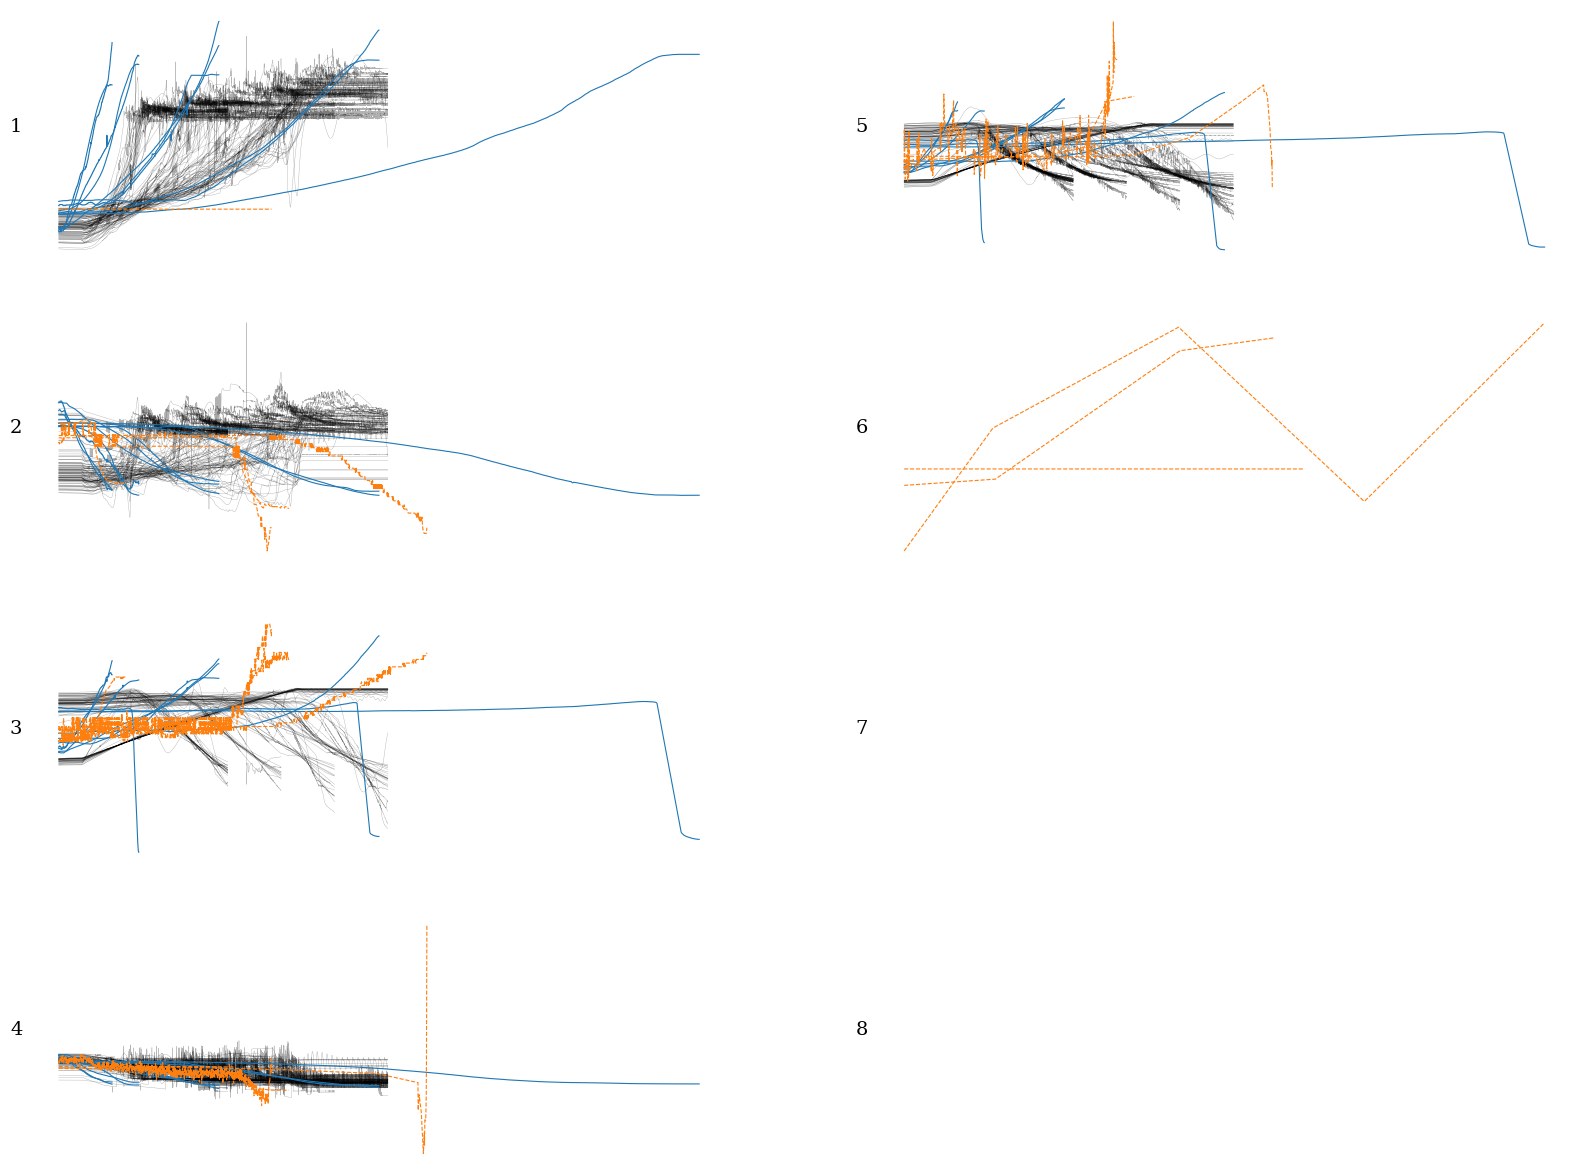

In [6]:
fig, ax1 = plt.subplots(4, 2, figsize=(20, 15))#sharex=True,

alphabet = "SDW"

for key in sorted(dfs.keys(), key=lambda word: [alphabet.index(c) if c in alphabet else ord(c) for c in word]):
    
    if 'WELL' in key:
        c = color_cycle[1]
        lw = 0.8
        ls='--'
        alpha=1
        ms=0.1
    elif 'DRAWN' in key:
        c = color_cycle[0]
        lw = 0.8
        ls='-'
        alpha=1
        ms=0.1        
    elif 'SIMULATED' in key:
        c = 'k'
        lw = 0.3
        ls='-'
        alpha=0.3
        ms=0.1
        
    df_plot = dfs[key]
    
    for i in range(4):
        ax1[i,0].plot(np.arange(df_plot.shape[0]),
                    (df_plot.iloc[:,i]-df_plot.iloc[:,i].mean())/df_plot.iloc[:,i].std(ddof=1),
                     c=c,linewidth=lw,ls=ls,alpha=alpha)#marker='.',ms=ms,)
        if i + 4 < 7:
            ax1[i,1].plot(np.arange(df_plot.shape[0]),
                        (df_plot.iloc[:,i+4]-df_plot.iloc[:,i+4].mean())/df_plot.iloc[:,i+4].std(ddof=1),
                         c=c,linewidth=lw,ls=ls,alpha=alpha)#marker='.',ms=ms,)

        ax1[i][0].set_ylabel(i+1,rotation=0,fontsize=14)
        ax1[i][1].set_ylabel(i+1+4,rotation=0,fontsize=14)
        for j in range(2):
            ax1[i][j].set_yticks([])
            ax1[i][j].spines["top"].set_visible(False)
            ax1[i][j].spines["right"].set_visible(False)
            ax1[i][j].spines["left"].set_visible(False)
            if i<(7-1):
                ax1[i][j].set_xticks([])
                ax1[i][j].spines["bottom"].set_visible(False)
                ax1[i][j].xaxis.set_ticks_position('none')
            else:
                for label in ax1[i][j].get_xticklabels():
                    label.set_rotation(45)
                    label.set_ha('right')
                    
        gc.collect()


There are upward and downward trends in temperature variables (3, T-TPT and 5, T-JUS-CKP) for simulated and hand-drawn data, but only upward trends for those variables in real data.

In variable 2, P-TPT, there are upward and downward trends for simulated data, but only downward trends in real and hand-drawn data.

### Plotting all instances

The function below is for plotting faulty instances for the three available data types: simulated, hand-drawn and real data.

In [7]:
def plot_faulty_instances(n_rows, n_cols, figsize,data_type='WELL'):
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    subfigs = fig.subfigures(n_rows, n_cols, wspace=0.07)

    title = {'SIMULATED': 'Simulation',
             'DRAWN': 'Drawn data',
             'WELL': 'Well'}

    if data_type == 'SIMULATED' or data_type == 'DRAWN':
        slice_number = slice(-5,None)
    elif data_type == 'WELL':
        slice_number = slice(5,10)

    j=0

    for key in sorted(dfs.keys()):        
        if data_type not in key:
            continue

        df_plot = dfs[key]
        ax = subfigs.ravel()[j].subplots(7, 1, sharex=True)

        for i in range(7):
            ax[i].plot(df_plot.index,df_plot.iloc[:,i],c='k',linewidth=0.8)
            ax[i].set_ylabel(i+1,rotation=0,fontsize=14)
            ax[i].set_yticks([])
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].spines["left"].set_visible(False)
            ax[i].fill_between(df_plot.index, ax[i].get_ylim()[0], ax[i].get_ylim()[1],
                                where=(df_plot['class']==(EVENT+100)).to_numpy(dtype=bool, na_value=False), 
                                alpha=0.2,color='red')
            ax[i].fill_between(df_plot.index,ax[i].get_ylim()[0], ax[i].get_ylim()[1],
                                where=(df_plot['class']==EVENT).to_numpy(dtype=bool, na_value=False), 
                                alpha=0.6,color='red')
            ax[i].set_xticks([])
            ax[i].spines["bottom"].set_visible(False)
            ax[i].xaxis.set_ticks_position('none')
        
        title_str = title[data_type]+f' {int(key[slice_number])}'
        if data_type == 'WELL':
            title_str = title_str + f'\n {df_plot.index[0]} to {df_plot.index[-1]}'
        ax[0].set_title(title_str)
        
        gc.collect()

        j+=1

    # suptitle instead of title makes the execution very slow, because of the constrained_layout used
    #for j in range(len(subfigs.ravel())):
    #    subfigs.ravel()[j].suptitle(f'Simulation {int(key[-5:])}')

In the following graphs, the light red background indicates faulty transient periods, in which the abnormal events are still developing; the dark red background indicates faulty steady-state periods, in which the abnormal events are fully developed.

#### Simulated data

CPU times: user 1min 7s, sys: 2.12 s, total: 1min 9s
Wall time: 1min 9s


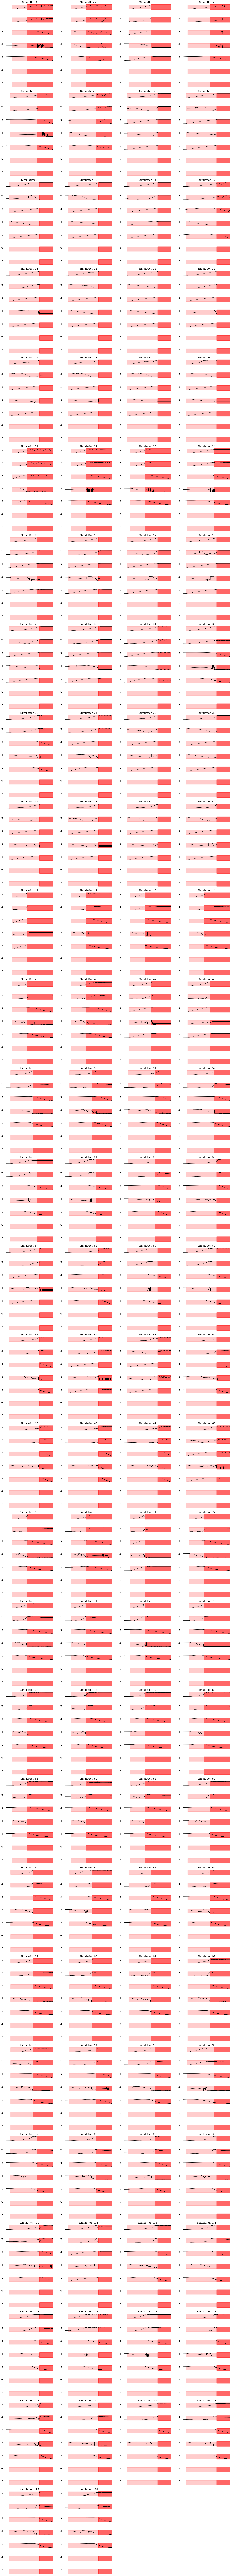

In [8]:
%%time

plot_faulty_instances(29,4,(18,200),'SIMULATED')

Some transient periods are longer than others. Variable 4 seems the most affected by the event, with visible disturbances during the transient and steady-state phases.

#### Hand-drawn data

CPU times: user 5.51 s, sys: 135 ms, total: 5.64 s
Wall time: 5.66 s


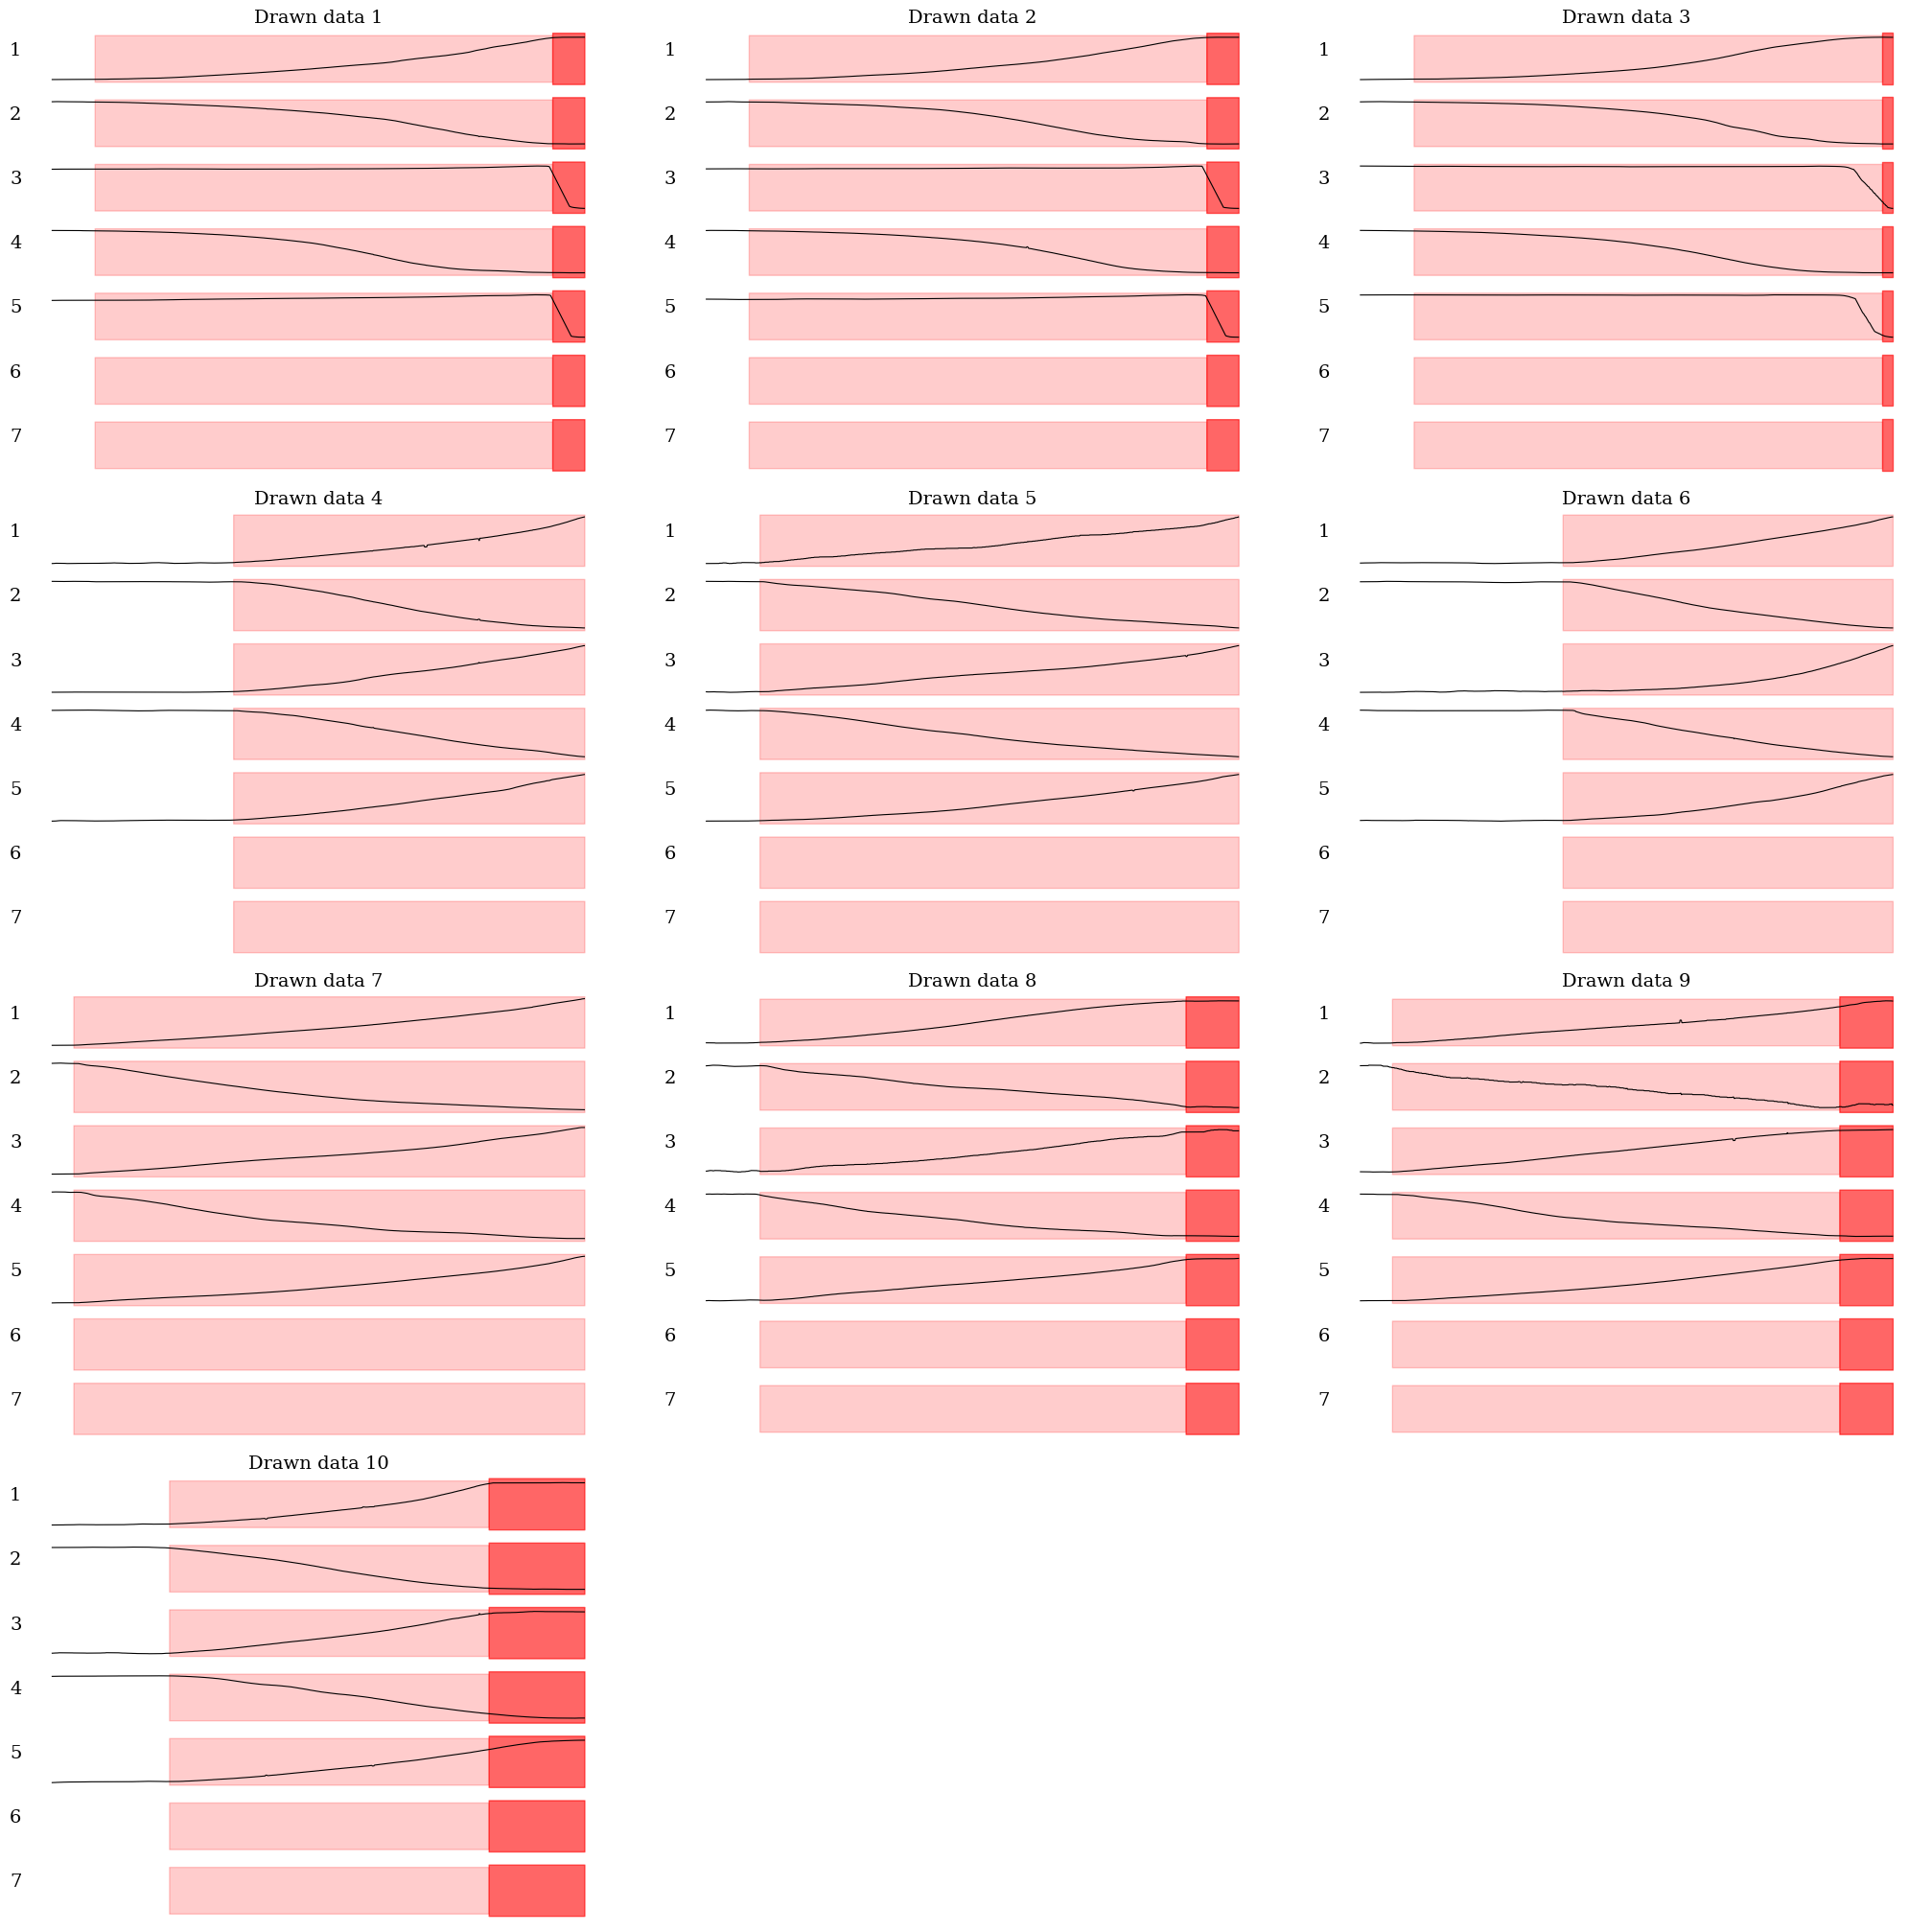

In [9]:
%%time

plot_faulty_instances(4,3,(20,20),'DRAWN')

The drawn data is remarkably simple, consisting only of correlated trends.

#### Real data

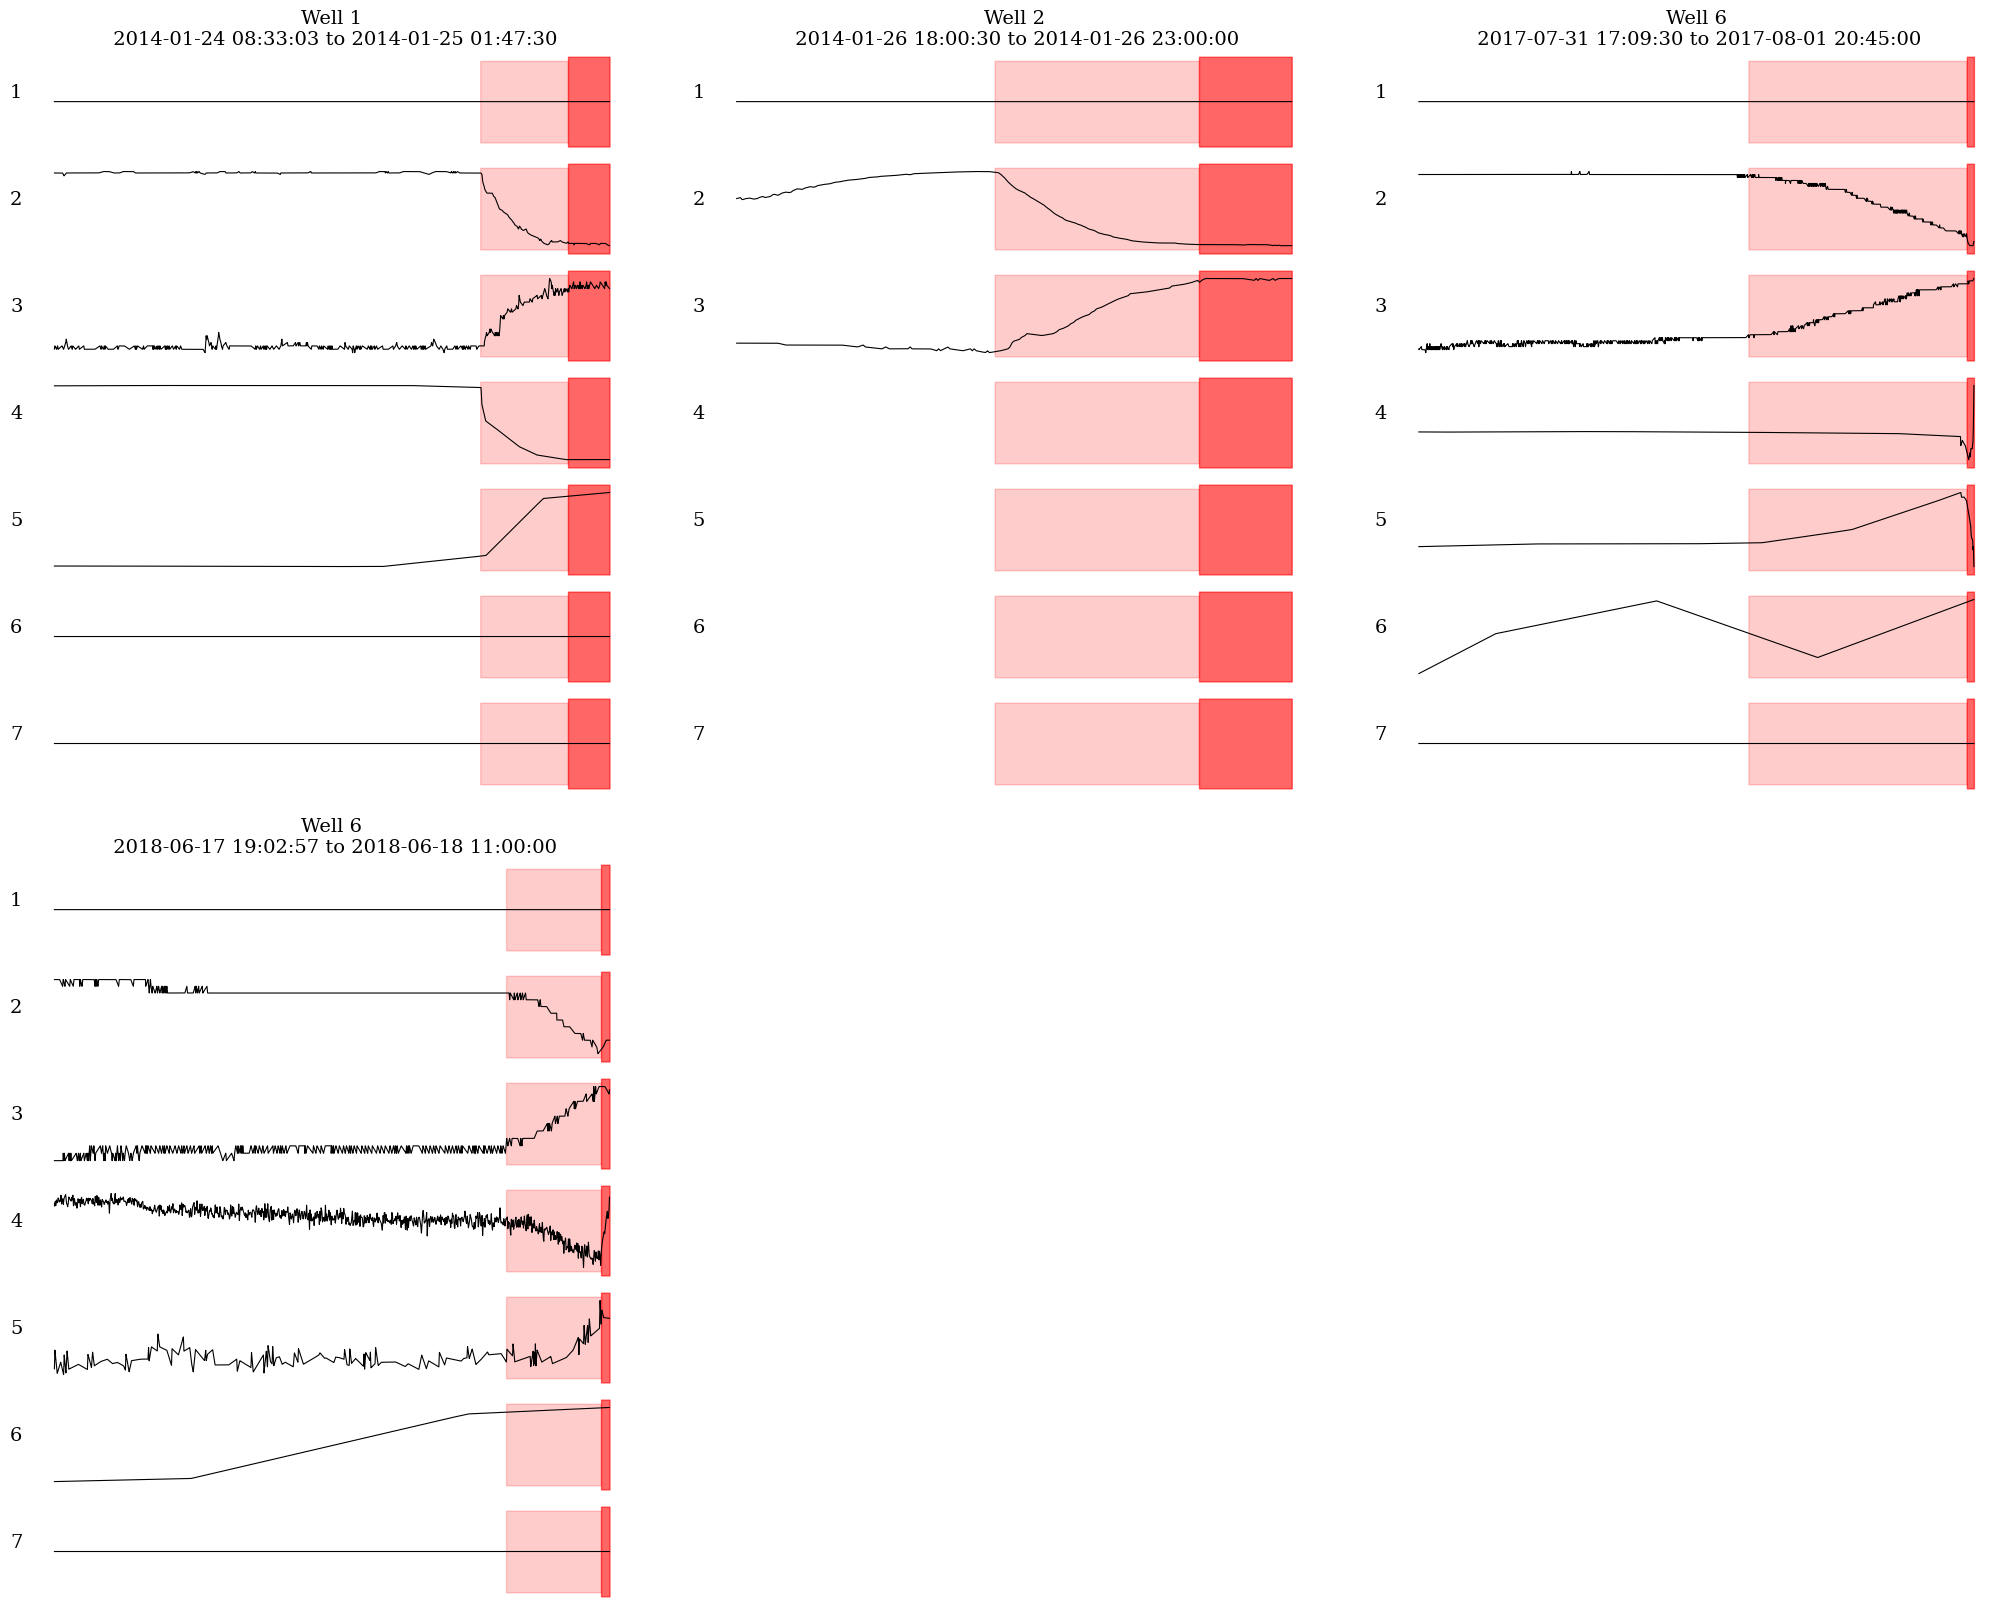

In [10]:
# %%time

plot_faulty_instances(2,3,(20,16),'WELL')

As in simulated and drawn data, during normal periods, many of the variables are stable; in transient phases, upward and downward trends begin to take place.

Unlike simulated and hand-drawn data, there is consistency in the orientation of trends for all variables across the five instances.